In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# Derivadas parciales para regresión lineal
# ####################################################################
def der_parcial_1(xs: list, ys: list) -> tuple[float, float, float]:
    """Retorna los coeficientes de la ecuación de la derivada parcial con respecto al parámetro 1 al reemplazar los valores ``xs`` y ``ys``. La ecuación es de la forma:
    c_1 * a_1 + c_0 * a_0 = c_ind


    ## Parameters

    ``xs``: lista de valores de x.

    ``ys``: lista de valores de y.

    ## Return

    ``c_1``: coeficiente del parámetro 1.

    ``c_0``: coeficiente del parámetro 0.

    ``c_ind``: coeficiente del término independiente.

    """

    # coeficiente del término independiente
    c_ind = sum(ys)

    # coeficiente del parámetro 1
    c_1 = sum(xs)

    # coeficiente del parámetro 0
    c_0 = len(xs)

    return (c_1, c_0, c_ind)


def der_parcial_0(xs: list, ys: list) -> tuple[float, float, float]:
    """Retorna los coeficientes de la ecuación de la derivada parcial con respecto al parámetro 0 al reemplazar los valores ``xs`` y ``ys``. La ecuación es de la forma:
    c_1 * a_1 + c_0 * a_0 = c_ind

    ## Parameters
    ``xs``: lista de valores de x.
    ``ys``: lista de valores de y.

    ## Return
    ``c_1``: coeficiente del parámetro 1.
    ``c_0``: coeficiente del parámetro 0.
    ``c_ind``: coeficiente del término independiente.
    """
    c_1 = 0
    c_0 = 0
    c_ind = 0
    for xi, yi in zip(xs, ys):
        # coeficiente del término independiente
        c_ind += xi * yi

        # coeficiente del parámetro 1
        c_1 += xi * xi

        # coeficiente del parámetro 0
        c_0 += xi

    return (c_1, c_0, c_ind)

In [2]:
xs = [
    -5.0000,
    -3.8889,
    -2.7778,
    -1.6667,
    -0.5556,
    0.5556,
    1.6667,
    2.7778,
    3.8889,
    5.0000,
]
ys = [
    -12.7292,
    -7.5775,
    -7.7390,
    -4.1646,
    -4.5382,
    2.2048,
    4.3369,
    2.2227,
    9.0625,
    7.1860,
]

In [18]:
# -*- coding: utf-8 -*-

"""
Python 3
17 / 07 / 2024
@author: z_tjona

"I find that I don't understand things unless I try to program them."
- Donald E. Knuth
"""

# ----------------------------- logging --------------------------
import logging
from sys import stdout
from datetime import datetime

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s][%(levelname)s] %(message)s",
    stream=stdout,
    datefmt="%m-%d %H:%M:%S",
)
logging.info("Inicio del programa")

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# ######################### Función de Eliminación Gaussiana #########################

def eliminacion_gaussiana(Ab: np.ndarray) -> np.ndarray:
    """
    Resuelve un sistema de ecuaciones lineales utilizando la eliminación gaussiana.
    Recibe una matriz aumentada Ab (de coeficientes + término independiente) y devuelve
    el vector de soluciones.

    ## Parameters
    Ab : np.ndarray
        Matriz aumentada del sistema de ecuaciones.

    ## Return
    np.ndarray
        El vector con los valores de las incógnitas.
    """
    logging.info("Iniciando eliminación gaussiana")
    # Número de filas (o incógnitas)
    n = len(Ab)

    # Eliminación hacia adelante
    for i in range(n):
        # Asegurarse de que el pivote sea no nulo
        if Ab[i, i] == 0:
            for j in range(i + 1, n):
                if Ab[j, i] != 0:
                    # Intercambiar filas
                    Ab[i], Ab[j] = Ab[j].copy(), Ab[i].copy()
                    logging.debug(f"Intercambiando filas {i} y {j}")
                    break
            else:
                raise ValueError("Sistema no tiene solución única")

        # Normalizar la fila
        Ab[i] = Ab[i] / Ab[i, i]
        logging.debug(f"Fila {i} normalizada")

        # Eliminar las variables debajo del pivote
        for j in range(i + 1, n):
            Ab[j] = Ab[j] - Ab[j, i] * Ab[i]
            logging.debug(f"Eliminando variable en columna {i}, fila {j}")

    # Sustitución hacia atrás
    soluciones = np.zeros(n)
    for i in range(n - 1, -1, -1):
        soluciones[i] = Ab[i, -1] - np.dot(Ab[i, i + 1:n], soluciones[i + 1:n])
        logging.debug(f"Solución para variable {i}: {soluciones[i]}")

    logging.info("Eliminación gaussiana completada")
    return soluciones

# ######################## Función Ajustar Mínimos Cuadrados ########################

def ajustar_min_cuadrados(
    xs: list,
    ys: list,
    gradiente: list[Callable[[list[float], list[float]], tuple]],
) -> list[float]:
    """
    Resuelve el sistema de ecuaciones para encontrar los parámetros del método de mínimos cuadrados.
    Plantea el sistema de ecuaciones lineales al reemplazar los valores de ``xs`` y ``ys`` en las derivadas parciales.

    ## Parameters

    xs : list
        Lista con los valores de x.

    ys : list
        Lista con los valores de y.

    gradiente : list[Callable]
        Lista con las funciones de derivadas parciales de ``fcn``.
        [IMPORTANTE] Cada función debe ser de la forma
        der_parcial(xi, yi) -> (c_n, c_(n-1), ..., c_1, c_0, c_ind)

    ## Return

    list[float]
        Lista con los parámetros ajustados, e.g. (a_n, a_(n-1), ..., a_1, a_0).
    """
    logging.info("Iniciando ajuste por mínimos cuadrados")
    assert len(xs) == len(ys), "xs y ys deben tener la misma longitud."

    num_pars = len(gradiente)
    logging.info(f"Se ajustarán {num_pars} parámetros.")
    # --- construir matriz A y vector b
    Ab = np.zeros((num_pars, num_pars + 1), dtype=float)

    for i, der_parcial in enumerate(gradiente):
        assert callable(der_parcial), "Cada derivada parcial debe ser una función."
        Ab[i, :] = der_parcial(xs, ys)
        logging.debug(f"Fila {i} de la matriz aumentada: {Ab[i, :]}")

    # Resolver el sistema de ecuaciones usando eliminación gaussiana
    soluciones = eliminacion_gaussiana(Ab)
    logging.info("Ajuste por mínimos cuadrados completado")
    return list(soluciones)

# ################### Definición de Funciones de Derivadas Parciales ####################

# Para ajuste cuadrático: y = a2 * x^2 + a1 * x + a0
def der_parcial_a2(xs: list, ys: list) -> tuple:
    sum_x4 = sum(x**4 for x in xs)
    sum_x3 = sum(x**3 for x in xs)
    sum_x2 = sum(x**2 for x in xs)
    sum_x2y = sum(x**2 * y for x, y in zip(xs, ys))
    logging.debug(f"der_parcial_a2: sum_x4={sum_x4}, sum_x3={sum_x3}, sum_x2={sum_x2}, sum_x2y={sum_x2y}")
    return (sum_x4, sum_x3, sum_x2, sum_x2y)

def der_parcial_a1(xs: list, ys: list) -> tuple:
    sum_x3 = sum(x**3 for x in xs)
    sum_x2 = sum(x**2 for x in xs)
    sum_x = sum(x for x in xs)
    sum_xy = sum(x * y for x, y in zip(xs, ys))
    logging.debug(f"der_parcial_a1: sum_x3={sum_x3}, sum_x2={sum_x2}, sum_x={sum_x}, sum_xy={sum_xy}")
    return (sum_x3, sum_x2, sum_x, sum_xy)

def der_parcial_a0(xs: list, ys: list) -> tuple:
    sum_x2 = sum(x**2 for x in xs)
    sum_x = sum(x for x in xs)
    n = len(xs)
    sum_y = sum(ys)
    logging.debug(f"der_parcial_a0: sum_x2={sum_x2}, sum_x={sum_x}, n={n}, sum_y={sum_y}")
    return (sum_x2, sum_x, n, sum_y)

# Para ajuste exponencial linealizado: ln(y) = A + b * x, donde A = ln(a)
def der_parcial_A_linear(xs: list, y_logs: list) -> tuple:
    sum_1 = len(xs)
    sum_x = sum(xs)
    sum_y = sum(y_logs)
    logging.debug(f"der_parcial_A_linear: sum_1={sum_1}, sum_x={sum_x}, sum_y={sum_y}")
    return (sum_1, sum_x, sum_y)

def der_parcial_b_linear(xs: list, y_logs: list) -> tuple:
    sum_x = sum(xs)
    sum_x2 = sum(x**2 for x in xs)
    sum_xy = sum(x * y for x, y in zip(xs, y_logs))
    logging.debug(f"der_parcial_b_linear: sum_x={sum_x}, sum_x2={sum_x2}, sum_xy={sum_xy}")
    return (sum_x, sum_x2, sum_xy)

# ################### Definición de Funciones para los Modelos ####################

# Modelo Cuadrático
def modelo_cuadratico(x: float, a2: float, a1: float, a0: float) -> float:
    return a2 * x**2 + a1 * x + a0

# Modelo Exponencial
def modelo_exponencial(x: float, a: float, b: float) -> float:
    return a * np.exp(b * x)

In [20]:
# Ajuste Cuadrático para el Conjunto de Datos 1
logging.info("Ajustando modelo cuadrático para el Conjunto de Datos 1")
gradiente_cuadratico = [der_parcial_a2, der_parcial_a1, der_parcial_a0]
params_cuadratico = ajustar_min_cuadrados(xs1, ys1, gradiente_cuadratico)
a2, a1, a0 = params_cuadratico
logging.info(f"Parámetros ajustados para modelo cuadrático: a2={a2}, a1={a1}, a0={a0}")

# Calculando y para x=2.25 y x=-2.25
x_values = [2.25, -2.25]
y_values = [modelo_cuadratico(x, a2, a1, a0) for x in x_values]
logging.info(f"y({x_values[0]}) = {y_values[0]:.4f}")
logging.info(f"y({x_values[1]}) = {y_values[1]:.4f}")

# Ajuste Exponencial para el Conjunto de Datos 2 (Linealizado)
logging.info("Ajustando modelo exponencial para el Conjunto de Datos 2 mediante linealización")
# Transformar y a log(y)
y_logs2 = [np.log(y) for y in ys2]
gradiente_exponencial = [der_parcial_A_linear, der_parcial_b_linear]
params_exponencial_lineal = ajustar_min_cuadrados(xs2, y_logs2, gradiente_exponencial)
A, b = params_exponencial_lineal
a = np.exp(A)
logging.info(f"Parámetros ajustados para modelo exponencial: a={a}, b={b}")

In [21]:
xs1 = [
    -5.0000,
    -3.8889,
    -2.7778,
    -1.6667,
    -0.5556,
    0.5556,
    1.6667,
    2.7778,
    3.8889,
    5.0000,
]
ys1 = [
    57.2441,
    33.0303,
    16.4817,
    7.0299,
    0.5498,
    0.7117,
    3.4185,
    12.1767,
    24.9167,
    44.2495,
]

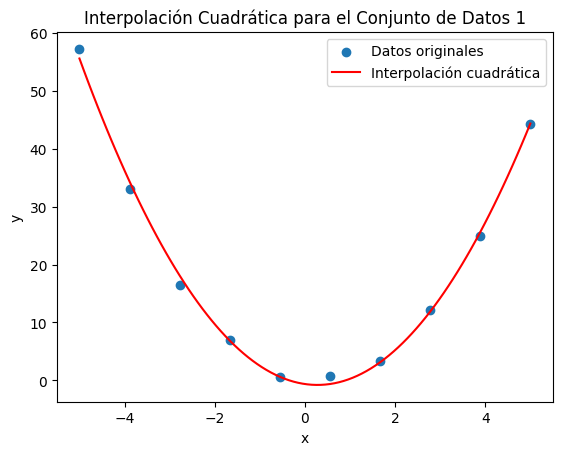


### Resultados del Ajuste por Mínimos Cuadrados ###

Conjunto de Datos 1 (Cuadrático):
a2: 2.0244
a1: -1.1233
a0: -0.6383
y(2.25): 7.0828
y(-2.25): 12.1378



In [22]:
# Interpolación cuadrática para el conjunto de datos 1
coefs = np.polyfit(xs1, ys1, 2)

# Crear los valores de x para la curva ajustada
x_fit = np.linspace(min(xs1), max(xs1), 100)
y_fit = np.polyval(coefs, x_fit)

# Graficar los datos originales y la interpolación cuadrática
plt.scatter(xs1, ys1, label="Datos originales")
plt.plot(x_fit, y_fit, color="red", label="Interpolación cuadrática")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Interpolación Cuadrática para el Conjunto de Datos 1")
plt.legend()
plt.show()

print("\n### Resultados del Ajuste por Mínimos Cuadrados ###\n")

# Resultados para Conjunto de Datos 1
print("Conjunto de Datos 1 (Cuadrático):")
print(f"a2: {a2:.4f}")
print(f"a1: {a1:.4f}")
print(f"a0: {a0:.4f}")
print(f"y(2.25): {y_values[0]:.4f}")
print(f"y(-2.25): {y_values[1]:.4f}\n")

In [16]:
xs2 = [
    0.0003,
    0.0822,
    0.2770,
    0.4212,
    0.4403,
    0.5588,
    0.5943,
    0.6134,
    0.9070,
    1.0367,
    1.1903,
    1.2511,
    1.2519,
    1.2576,
    1.6165,
    1.6761,
    2.0114,
    2.0557,
    2.1610,
    2.6344,
]
ys2 = [
    1.1017,
    1.5021,
    0.3844,
    1.3251,
    1.7206,
    1.9453,
    0.3894,
    0.3328,
    1.2887,
    3.1239,
    2.1778,
    3.1078,
    4.1856,
    3.3640,
    6.0330,
    5.8088,
    10.5890,
    11.5865,
    11.8221,
    26.5077,
]

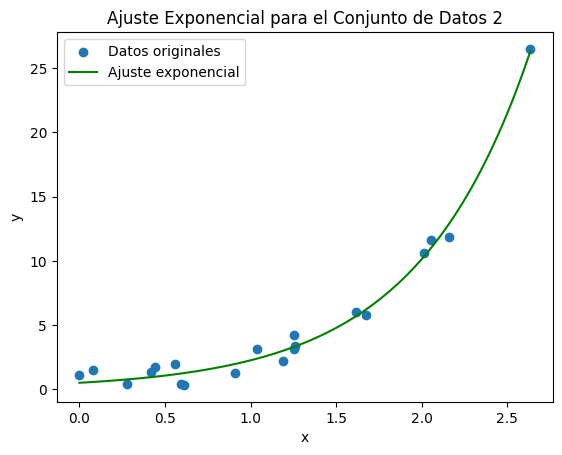

Conjunto de Datos 2 (Exponencial):
a: 0.5441
b: 1.4172


In [23]:
# Definir la función exponencial
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Ajustar la función exponencial a los datos
params, _ = curve_fit(exp_func, xs2, ys2, p0=[1, 1])

# Crear los valores de x para la curva ajustada
x_fit2 = np.linspace(min(xs2), max(xs2), 100)
y_fit2 = exp_func(x_fit2, *params)

# Graficar los datos originales y la curva ajustada exponencialmente
plt.scatter(xs2, ys2, label="Datos originales")
plt.plot(x_fit2, y_fit2, color="green", label="Ajuste exponencial")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste Exponencial para el Conjunto de Datos 2")
plt.legend()
plt.show()

# Resultados para Conjunto de Datos 2
print("Conjunto de Datos 2 (Exponencial):")
print(f"a: {a:.4f}")
print(f"b: {b:.4f}")